# Machine Learning System Design


## Introduction and Initial Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import json
import logging
import sys
from pathlib import Path

import ipytest

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

import boto3
import sagemaker
from sagemaker.workflow.pipeline_context import LocalPipelineSession, PipelineSession
from sagemaker.workflow.steps import CacheConfig
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

CODE_FOLDER = Path("code")
CODE_FOLDER.mkdir(exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[01/20/25 16:20:57] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=807691;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=683304;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py#1278\1278]8;;\

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/anchit/Library/Application Support/sagemaker/config.yaml


In [29]:
logger = logging.getLogger("sagemaker.config")
logger.setLevel(logging.ERROR)

In [30]:
LOCAL_MODE = False

In [31]:
bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

COMET_API_KEY = os.environ.get("COMET_API_KEY", None)
COMET_PROJECT_NAME = os.environ.get("COMET_PROJECT_NAME", None)

In [32]:
# print(bucket)
# print(role)
# print(COMET_PROJECT_NAME)

In [33]:
# We can retrieve the architecture of the local
# computer using the `uname -m` command.
architecture = !(uname -m)

IS_ARM64_ARCHITECTURE = architecture[0] == "arm64"

In [34]:
pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(default_bucket=bucket),
        "instance_type": "local",
        # We need to use a custom Docker image when we run the pipeline
        # in Local Model on an ARM64 machine.
        "image": (
            "sagemaker-tensorflow-toolkit-local" if IS_ARM64_ARCHITECTURE else None
        ),
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "image": None,
    }

# These specific settings refer to the SageMaker
# Pytorch container we'll use.
config["framework_version"] = "2.12"
config["py_version"] = "py310"

In [35]:
S3_LOCATION = f"s3://{bucket}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

## EDA

In [36]:
penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
3  Adelie  Torgersen               NaN              NaN                NaN   
4  Adelie  Torgersen              36.7             19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE

In [37]:
penguins.describe(include="all")

species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
count      344     344        342.000000       342.000000         342.000000   
unique       3       3               NaN              NaN                NaN   
top     Adelie  Biscoe               NaN              NaN                NaN   
freq       152     168               NaN              NaN                NaN   
mean       NaN     NaN         43.921930        17.151170         200.915205   
std        NaN     NaN          5.459584         1.974793          14.061714   
min        NaN     NaN         32.100000        13.100000         172.000000   
25%        NaN     NaN         39.225000        15.600000         190.000000   
50%        NaN     NaN         44.450000        17.300000         197.000000   
75%        NaN     NaN         48.500000        18.700000         213.000000   
max        NaN     NaN         59.600000        21.500000         231.000000   

        body_mass_g   sex  
count    342.000000   334  
unique          NaN     3  
top             NaN  MALE  
freq            NaN   168  
mean    4201.754386   NaN  
std      801.954536   NaN  
min     2700.000000   NaN  
25%     3550.000000   NaN  
50%     4050.000000   NaN  
75%     4750.000000   NaN  
max     6300.000000   NaN

In [38]:
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution, end="\n\n")
print(island_distribution, end="\n\n")
print(sex_distribution)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


In [39]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)

# Let's display the new distribution of the column:
sex_distribution = penguins["sex"].value_counts()
sex_distribution

sex
MALE      168
FEMALE    165
Name: count, dtype: int64

### Deling with Missing Values

In [40]:
imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:, :] = imputer.fit_transform(penguins)

# Let's display again the number of missing values:
penguins.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

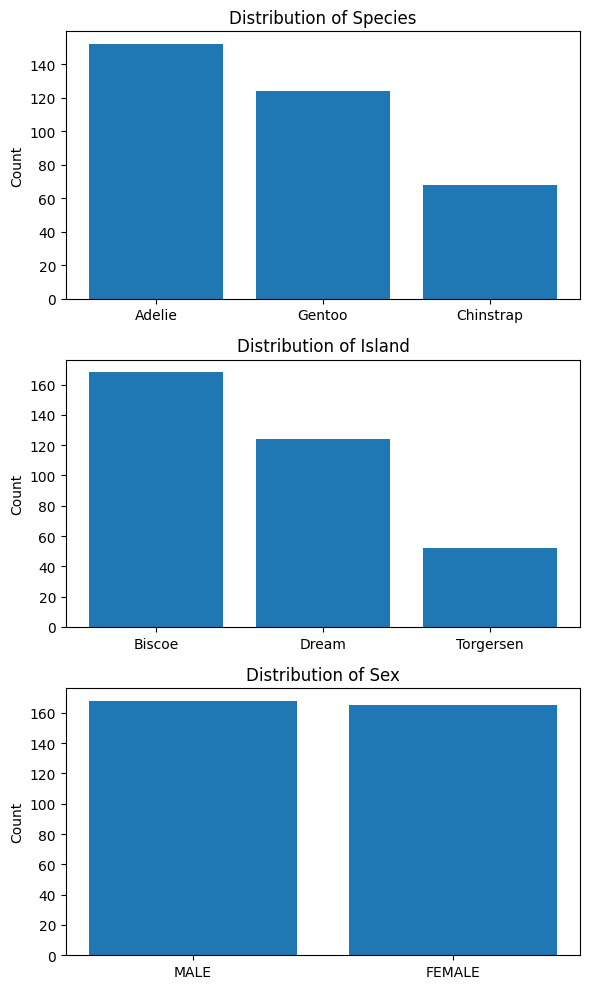

In [41]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()

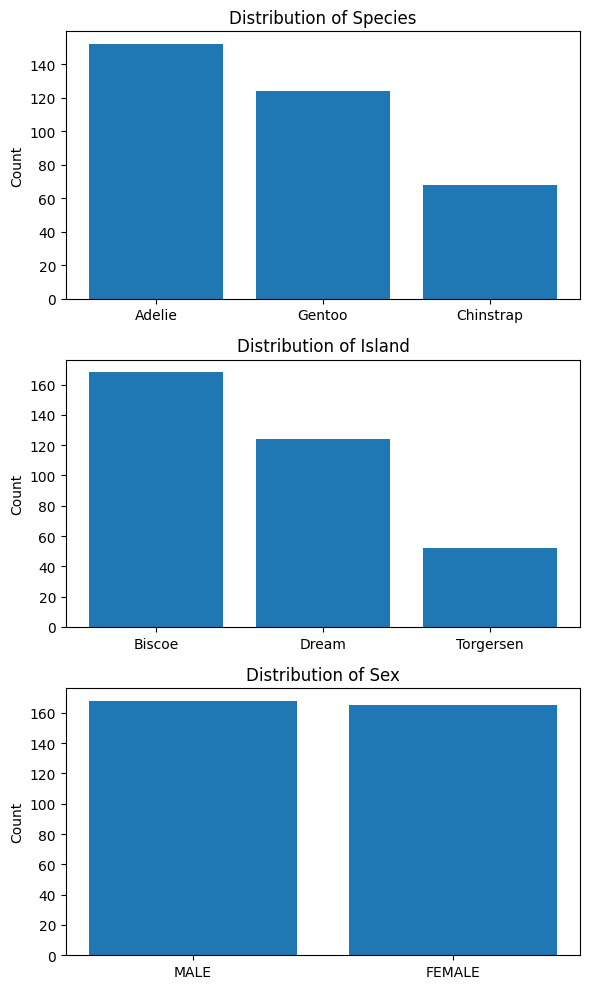

: 

: 

: 

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()

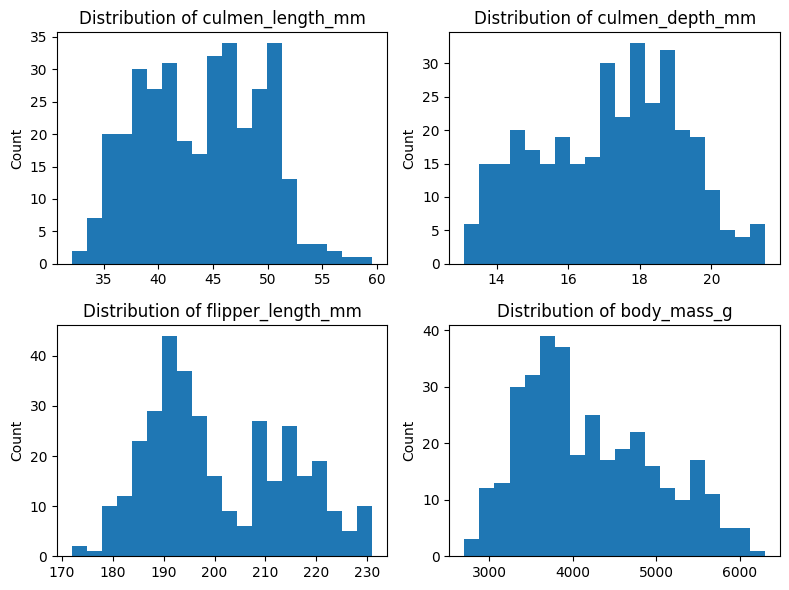

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(penguins["culmen_length_mm"], bins=20)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of culmen_length_mm")

axs[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of culmen_depth_mm")

axs[1, 0].hist(penguins["flipper_length_mm"], bins=20)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of flipper_length_mm")

axs[1, 1].hist(penguins["body_mass_g"], bins=20)
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Distribution of body_mass_g")

plt.tight_layout()
plt.show()

In [43]:
penguins.cov(numeric_only=True)

culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
culmen_length_mm          29.679415        -2.516984          50.260588   
culmen_depth_mm           -2.516984         3.877201         -16.108849   
flipper_length_mm         50.260588       -16.108849         197.269501   
body_mass_g             2596.971151      -742.660180        9792.552037   

                     body_mass_g  
culmen_length_mm     2596.971151  
culmen_depth_mm      -742.660180  
flipper_length_mm    9792.552037  
body_mass_g        640316.716388

In [44]:
penguins.corr(numeric_only=True)

culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
culmen_length_mm           1.000000        -0.234635           0.656856   
culmen_depth_mm           -0.234635         1.000000          -0.582472   
flipper_length_mm          0.656856        -0.582472           1.000000   
body_mass_g                0.595720        -0.471339           0.871302   

                   body_mass_g  
culmen_length_mm      0.595720  
culmen_depth_mm      -0.471339  
flipper_length_mm     0.871302  
body_mass_g           1.000000

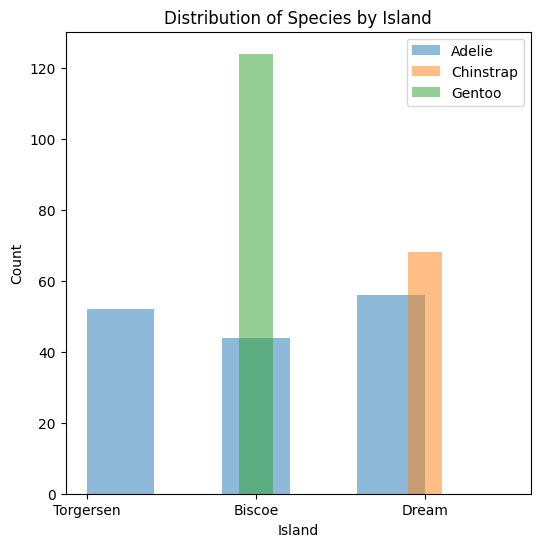

In [45]:
unique_species = penguins["species"].unique()

fig, ax = plt.subplots(figsize=(6, 6))
for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["island"], bins=5, alpha=0.5, label=species)

ax.set_xlabel("Island")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Island")
ax.legend()
plt.show()

## Transforming the Data

### Preprocessing Script

In [46]:
(CODE_FOLDER / "processing").mkdir(parents=True, exist_ok=True)

In [47]:
%%writefile {CODE_FOLDER}/processing/script.py
# | filename: script.py
# | code-line-numbers: true

import os
import tarfile
import tempfile
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


def preprocess(base_directory):
    """Load the supplied data, split it and transform it."""
    df = _read_data_from_input_csv_files(base_directory)

    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])],
    )

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler(),
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(),
    )

    features_transformer = ColumnTransformer(
        transformers=[
            (
                "numeric",
                numeric_transformer,
                make_column_selector(dtype_exclude="object"),
            ),
            ("categorical", categorical_transformer, ["island"]),
        ],
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_train_baseline(base_directory, df_train)
    _save_test_baseline(base_directory, df_test)

    y_train = target_transformer.fit_transform(
        np.array(df_train.species.values).reshape(-1, 1),
    )
    y_validation = target_transformer.transform(
        np.array(df_validation.species.values).reshape(-1, 1),
    )
    y_test = target_transformer.transform(
        np.array(df_test.species.values).reshape(-1, 1),
    )

    df_train = df_train.drop("species", axis=1)
    df_validation = df_validation.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    X_train = features_transformer.fit_transform(df_train)  # noqa: N806
    X_validation = features_transformer.transform(df_validation)  # noqa: N806
    X_test = features_transformer.transform(df_test)  # noqa: N806

    _save_splits(
        base_directory,
        X_train,
        y_train,
        X_validation,
        y_validation,
        X_test,
        y_test,
    )
    _save_model(base_directory, target_transformer, features_transformer)


def _read_data_from_input_csv_files(base_directory):
    """Read the data from the input CSV files.

    This function reads every CSV file available and
    concatenates them into a single dataframe.
    """
    input_directory = Path(base_directory) / "input"
    files = list(input_directory.glob("*.csv"))

    if len(files) == 0:
        message = f"The are no CSV files in {input_directory.as_posix()}/"
        raise ValueError(message)

    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)

    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """Split the data into train, validation, and test."""
    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_train_baseline(base_directory, df_train):
    """Save the untransformed training data to disk.

    We will need the training data to compute a baseline to
    determine the quality of the data that the model receives
    when deployed.
    """
    baseline_path = Path(base_directory) / "train-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_train.copy().dropna()

    # To compute the data quality baseline, we don't need the
    # target variable, so we'll drop it from the dataframe.
    df = df.drop("species", axis=1)

    df.to_csv(baseline_path / "train-baseline.csv", header=True, index=False)


def _save_test_baseline(base_directory, df_test):
    """Save the untransformed test data to disk.

    We will need the test data to compute a baseline to
    determine the quality of the model predictions when deployed.
    """
    baseline_path = Path(base_directory) / "test-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_test.copy().dropna()

    # We'll use the test baseline to generate predictions later,
    # and we can't have a header line because the model won't be
    # able to make a prediction for it.
    df.to_csv(baseline_path / "test-baseline.csv", header=False, index=False)


def _save_splits(
    base_directory,
    X_train,  # noqa: N803
    y_train,
    X_validation,  # noqa: N803
    y_validation,
    X_test,  # noqa: N803
    y_test,
):
    """Save data splits to disk.

    This function concatenates the transformed features
    and the target variable, and saves each one of the split
    sets to disk.
    """
    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        validation_path / "validation.csv",
        header=False,
        index=False,
    )
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """Save the Scikit-Learn transformation pipelines.

    This function creates a model.tar.gz file that
    contains the two transformation pipelines we built
    to transform the data.
    """
    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, Path(directory) / "target.joblib")
        joblib.dump(features_transformer, Path(directory) / "features.joblib")

        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)

        with tarfile.open(f"{(model_path / 'model.tar.gz').as_posix()}", "w:gz") as tar:
            tar.add(Path(directory) / "target.joblib", arcname="target.joblib")
            tar.add(
                Path(directory) / "features.joblib", arcname="features.joblib",
            )


if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Overwriting code/processing/script.py


In [48]:
%%ipytest -s
# | code-fold: true

import os
import shutil
import tarfile
import tempfile

import pytest
from processing.script import preprocess


@pytest.fixture(autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)
    preprocess(base_directory=directory)

    yield directory

    shutil.rmtree(directory)


def test_preprocess_generates_data_splits(directory):
    output_directories = os.listdir(directory)

    assert "train" in output_directories
    assert "validation" in output_directories
    assert "test" in output_directories


def test_preprocess_generates_baselines(directory):
    output_directories = os.listdir(directory)

    assert "train-baseline" in output_directories
    assert "test-baseline" in output_directories


def test_preprocess_creates_two_models(directory):
    model_path = directory / "model"
    tar = tarfile.open(model_path / "model.tar.gz", "r:gz")

    assert "features.joblib" in tar.getnames()
    assert "target.joblib" in tar.getnames()


def test_splits_are_transformed(directory):
    train = pd.read_csv(directory / "train" / "train.csv", header=None)
    validation = pd.read_csv(directory / "validation" / "validation.csv", header=None)
    test = pd.read_csv(directory / "test" / "test.csv", header=None)

    # After transforming the data, the number of features should be 7:
    # * 3 - island (one-hot encoded)
    # * 1 - culmen_length_mm = 1
    # * 1 - culmen_depth_mm
    # * 1 - flipper_length_mm
    # * 1 - body_mass_g
    number_of_features = 7

    # The transformed splits should have an additional column for the target
    # variable.
    assert train.shape[1] == number_of_features + 1
    assert validation.shape[1] == number_of_features + 1
    assert test.shape[1] == number_of_features + 1


def test_train_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "train-baseline" / "train-baseline.csv",
        header=None,
    )

    island = baseline.iloc[:, 0].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_test_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "test-baseline" / "test-baseline.csv", header=None
    )

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_train_baseline_includes_header(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv")
    assert baseline.columns[0] == "island"


def test_test_baseline_does_not_include_header(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv")
    assert baseline.columns[0] != "island"

........
8 passed in 0.48s


### Caching Configuration

In [49]:
cache_config = CacheConfig(enable_caching=True, expire_after="15d")

### Pipeline Configuration

In [50]:
pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)

### Setting up the Processing Step

In [51]:
processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    # By default, a new account doesn't have access to `ml.m5.xlarge` instances.
    # If you haven't requested a quota increase yet, you can use an
    # `ml.t3.medium` instance type instead. This will work out of the box, but
    # the Processing Job will take significantly longer than it should have.
    # To get access to `ml.m5.xlarge` instances, you can request a quota
    # increase under the Service Quotas section in your AWS account.
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

[01/20/25 16:25:16] INFO     Defaulting to only available Python version: py3                     ]8;id=609929;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=561753;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#608\608]8;;\

In [52]:
preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{(CODE_FOLDER / 'processing' / 'script.py').as_posix()}",
        inputs=[
            ProcessingInput(
                source=dataset_location,
                destination="/opt/ml/processing/input",
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="validation",
                source="/opt/ml/processing/validation",
                destination=f"{S3_LOCATION}/preprocessing/validation",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Creating the Pre Processing Pipeline

In [53]:
preprocessing_pipeline = Pipeline(
    name="preprocessing-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

preprocessing_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/preprocessing-pipeline',
 'ResponseMetadata': {'RequestId': 'c3f77b07-b73d-436d-b62d-a2930020a00e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c3f77b07-b73d-436d-b62d-a2930020a00e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '90',
   'date': 'Tue, 21 Jan 2025 00:25:21 GMT'},
  'RetryAttempts': 0}}

In [54]:
#preprocessing_pipeline.start()

## Training the Model

### Creating the Training Script

In [55]:
(CODE_FOLDER / "training").mkdir(parents=True, exist_ok=True)

In [56]:
%%writefile {CODE_FOLDER}/training/script.py
# | filename: script.py
# | code-line-numbers: true

import argparse
import json
import os
import tarfile

from pathlib import Path
from comet_ml import Experiment

import keras
import numpy as np
import pandas as pd
from keras import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from packaging import version
from sklearn.metrics import accuracy_score


def train(
    model_directory,
    train_path,
    validation_path,
    pipeline_path,
    experiment,
    epochs=50,
    batch_size=32,
):
    print(f"Keras version: {keras.__version__}")

    X_train = pd.read_csv(Path(train_path) / "train.csv")
    y_train = X_train[X_train.columns[-1]]
    X_train = X_train.drop(X_train.columns[-1], axis=1)

    X_validation = pd.read_csv(Path(validation_path) / "validation.csv")
    y_validation = X_validation[X_validation.columns[-1]]
    X_validation = X_validation.drop(X_validation.columns[-1], axis=1)

    model = Sequential(
        [
            Input(shape=(X_train.shape[1],)),
            Dense(10, activation="relu"),
            Dense(8, activation="relu"),
            Dense(3, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.fit(
        X_train,
        y_train,
        validation_data=(X_validation, y_validation),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
    )

    predictions = np.argmax(model.predict(X_validation), axis=-1)
    val_accuracy = accuracy_score(y_validation, predictions)
    print(f"Validation accuracy: {val_accuracy}")

    # Starting on version 3, Keras changed the model saving format.
    # Since we are running the training script using two different versions
    # of Keras, we need to check to see which version we are using and save
    # the model accordingly.
    model_filepath = (
        Path(model_directory) / "001"
        if version.parse(keras.__version__) < version.parse("3")
        else Path(model_directory) / "penguins.keras"
    )

    model.save(model_filepath)

    # Let's save the transformation pipelines inside the
    # model directory so they get bundled together.
    with tarfile.open(Path(pipeline_path) / "model.tar.gz", "r:gz") as tar:
        tar.extractall(model_directory)

    if experiment:
        experiment.log_parameters(
            {
                "epochs": epochs,
                "batch_size": batch_size,
            }
        )
        experiment.log_dataset_hash(X_train)
        experiment.log_confusion_matrix(
            y_validation.astype(int), predictions.astype(int)
        )
        experiment.log_model("penguins", model_filepath.as_posix())


if __name__ == "__main__":
    # Any hyperparameters provided by the training job are passed to
    # the entry point as script arguments.
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=32)
    args, _ = parser.parse_known_args()

    # Let's create a Comet experiment to log the metrics and parameters
    # of this training job.
    comet_api_key = os.environ.get("COMET_API_KEY", None)
    comet_project_name = os.environ.get("COMET_PROJECT_NAME", None)

    experiment = (
        Experiment(
            project_name=comet_project_name,
            api_key=comet_api_key,
            auto_metric_logging=True,
            auto_param_logging=True,
            log_code=True,
        )
        if comet_api_key and comet_project_name
        else None
    )

    training_env = json.loads(os.environ.get("SM_TRAINING_ENV", {}))
    job_name = training_env.get("job_name", None) if training_env else None

    # We want to use the SageMaker's training job name as the name
    # of the experiment so we can easily recognize it.
    if job_name and experiment:
        experiment.set_name(job_name)

    train(
        # This is the location where we need to save our model.
        # SageMaker will create a model.tar.gz file with anything
        # inside this directory when the training script finishes.
        model_directory=os.environ["SM_MODEL_DIR"],
        # SageMaker creates one channel for each one of the inputs
        # to the Training Step.
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        validation_path=os.environ["SM_CHANNEL_VALIDATION"],
        pipeline_path=os.environ["SM_CHANNEL_PIPELINE"],
        experiment=experiment,
        epochs=args.epochs,
        batch_size=args.batch_size,
    )

Overwriting code/training/script.py


In [57]:
%%ipytest -s
#| code-fold: true

import os
import shutil
import pytest
import tempfile

from processing.script import preprocess
from training.script import train

@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    train(
        model_directory=directory / "model",
        train_path=directory / "train", 
        validation_path=directory / "validation",
        pipeline_path=directory / "model",
        experiment=None,
        epochs=1
    )
    
    yield directory
    
    shutil.rmtree(directory)


def test_train_bundles_model_assets(directory):
    bundle = os.listdir(directory / "model")
    assert "001" in bundle
    
    assets = os.listdir(directory / "model" / "001")
    assert "saved_model.pb" in assets


def test_train_bundles_transformation_pipelines(directory):
    bundle = os.listdir(directory / "model")
    assert "target.joblib" in bundle
    assert "features.joblib" in bundle


2025-01-20 16:25:53.308502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras version: 2.14.0
8/8 - 1s - loss: 1.1564 - accuracy: 0.1925 - val_loss: 1.1539 - val_accuracy: 0.1765 - 1s/epoch - 130ms/step
2/2 [==============================] - 0s 3ms/step
Validation accuracy: 0.17647058823529413


[01/20/25 16:26:36] INFO     Assets written to:                                                 ]8;id=382971;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=153021;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmpp0k7rdae/model                    
                             /001/assets                                                                           

.Keras version: 2.14.0
8/8 - 0s - loss: 1.2005 - accuracy: 0.1506 - val_loss: 1.1775 - val_accuracy: 0.2549 - 490ms/epoch - 61ms/step
2/2 [==============================] - 0s 3ms/step
Validation accuracy: 0.2549019607843137


[01/20/25 16:26:38] INFO     Assets written to:                                                 ]8;id=107885;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=517866;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmpnz9yvshy/model                    
                             /001/assets                                                                           

.
2 passed in 3.55s


In [58]:
%%writefile {CODE_FOLDER}/training/requirements.txt
#| label: requirements.txt
#| filename: requirements.txt
#| code-line-numbers: false

comet-ml

Overwriting code/training/requirements.txt


In [59]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    base_job_name="training",
    entry_point="script.py",
    source_dir=f"{(CODE_FOLDER / 'training').as_posix()}",
    # SageMaker will pass these hyperparameters as arguments
    # to the entry point of the training script.
    hyperparameters={
        "epochs": 50,
        "batch_size": 32,
    },
    # SageMaker will create these environment variables on the
    # Training Job instance.
    environment={
        "COMET_API_KEY": COMET_API_KEY,
        "COMET_PROJECT_NAME": COMET_PROJECT_NAME,
    },
    # SageMaker will track these metrics as part of the experiment
    # associated to this pipeline. The metric definitions tells
    # SageMaker how to parse the values from the Training Job logs.
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    disable_profiler=True,
    debugger_hook_config=False,
    sagemaker_session=config["session"],
    role=role,
)

In [60]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


def create_training_step(estimator):
    """Create a SageMaker TrainingStep using the provided estimator."""
    return TrainingStep(
        name="train-model",
        step_args=estimator.fit(
            inputs={
                "train": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "train"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "validation": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "validation"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "pipeline": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "model"
                    ].S3Output.S3Uri,
                    content_type="application/tar+gzip",
                ),
            },
        ),
        cache_config=cache_config,
    )


train_model_step = create_training_step(estimator)

[01/20/25 16:27:59] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=847624;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=558868;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Creating the TF Pipeline

In [61]:
training_tf_pipeline = Pipeline(
    name="training-tf-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

training_tf_pipeline.upsert(role_arn=role)

[01/20/25 16:28:53] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=757540;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=610690;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/training-tf-pipeline',
 'ResponseMetadata': {'RequestId': 'd89c5a73-1a90-4b5b-8f69-41a54fc9ac68',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd89c5a73-1a90-4b5b-8f69-41a54fc9ac68',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '88',
   'date': 'Tue, 21 Jan 2025 00:28:53 GMT'},
  'RetryAttempts': 0}}

In [64]:
# training_tf_pipeline.start()

## Custom Training Container & ECR Image

### Preparing the Docker Image

In [67]:
import shutil

(CODE_FOLDER / "containers" / "training").mkdir(parents=True, exist_ok=True)
shutil.copy2(
    CODE_FOLDER / "training" / "script.py",
    CODE_FOLDER / "containers" / "training" / "train.py",
)

PosixPath('code/containers/training/train.py')

In [68]:
%%writefile {CODE_FOLDER}/containers/training/requirements.txt
# | filename: requirements.txt
# | code-line-numbers: true

sagemaker-training
packaging
keras
pandas
scikit-learn
comet_ml
jax[cpu]

Writing code/containers/training/requirements.txt


In [70]:
%%writefile {CODE_FOLDER}/containers/training/Dockerfile
# | filename: Dockerfile
# | code-line-numbers: true

FROM python:3.10-slim

RUN apt-get -y update && apt-get install -y --no-install-recommends \
    python3 \
    build-essential libssl-dev pkg-config libhdf5-dev

# Let's install the required Python packages from 
# the requirements.txt file.
COPY requirements.txt .
RUN pip install --user --upgrade pip
RUN pip3 install -r requirements.txt

# We are going to be running the training script
# as the entrypoint of this container.
COPY train.py /opt/ml/code/train.py
ENV SAGEMAKER_PROGRAM train.py

# We want to use JAX as the backend for Keras.
ENV KERAS_BACKEND=jax

Writing code/containers/training/Dockerfile


### Building the Docker Image

In [71]:
IMAGE_NAME = "keras-custom-training-container"

if not LOCAL_MODE:
    # If we aren't running the code in Local Mode, we need
    # to specify we want to build the Docker image for the
    # linux/amd64 architecture before uploading it to ECR.
    print("Building Docker image for linux/amd64 architecture...")

    !docker build --platform="linux/amd64" -t $IMAGE_NAME \
        $CODE_FOLDER/containers/training/
else:
    # If we are running in Local Mode, we can use the
    # default Docker build command.
    print("Building Docker image for arm64 architecture...")

    !docker build -t $IMAGE_NAME \
        $CODE_FOLDER/containers/training/

Building Docker image for linux/amd64 architecture...
[+] Building 0.0s (0/0)  docker:desktop-linux
[+] Building 0.0s (0/1)                                    docker:desktop-linux
[+] Building 0.2s (1/2)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 659B                                       0.0s
 => [internal] load metadata for docker.io/library/python:3.10-slim        0.1s
[+] Building 0.3s (1/2)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 659B                                       0.0s
 => [internal] load metadata for docker.io/library/python:3.10-slim        0.3s
[+] Building 0.5s (1/2)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring 

### Pushing Docker Image to ECR

In [72]:
%%bash -s "$LOCAL_MODE" "$IMAGE_NAME"
# | eval: false

algorithm_name=$2
account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration
# (default to us-east-1 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

repository="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# We only want to push the Docker image to ECR if
# we are not running in Local Mode.
if [ $1 = "False" ]
then
    # Create the repository if it doesn't exist in ECR
    aws ecr describe-repositories \
        --repository-names "${algorithm_name}" > /dev/null 2>&1
    if [ $? -ne 0 ]
    then
        aws ecr create-repository \
            --repository-name "${algorithm_name}" > /dev/null
    fi

    # Get the login command from ECR to run the
    # Docker push command.
    aws ecr get-login-password \
        --region ${region}|docker \
        login --username AWS --password-stdin ${repository}

    # Push the Docker image to the ECR repository
    docker tag ${algorithm_name} ${repository}
    docker push ${repository}
fi

Login Succeeded
The push refers to repository [418272792030.dkr.ecr.us-west-2.amazonaws.com/keras-custom-training-container]
bfdf52a7d0ed: Preparing
ed20485ef9a1: Preparing
a2fc647560c8: Preparing
739c8f9e83e6: Preparing
286bed057065: Preparing
102f36f0fcfd: Preparing
7a6f52e90804: Preparing
029e3473b943: Preparing
f5fe472da253: Preparing
7a6f52e90804: Waiting
029e3473b943: Waiting
f5fe472da253: Waiting
739c8f9e83e6: Pushed
bfdf52a7d0ed: Pushed
102f36f0fcfd: Pushed
029e3473b943: Pushed
a2fc647560c8: Pushed
7a6f52e90804: Pushed
f5fe472da253: Pushed
286bed057065: Pushed
ed20485ef9a1: Pushed
latest: digest: sha256:993f56998b949859b2ca88ad1ef465d467fb2d5638e611b6a2f85f681000dec3 size: 2211


### Setting up the Training Step

In [73]:
account_id = boto3.client("sts").get_caller_identity().get("Account")
tag = ":latest"

uri_suffix = "amazonaws.com"
if region in ["cn-north-1", "cn-northwest-1"]:
    uri_suffix = "amazonaws.com.cn"

training_container_image = (
    IMAGE_NAME
    if LOCAL_MODE
    else (f"{account_id}.dkr.ecr.{region}.amazonaws.com/{IMAGE_NAME}:latest")
)

training_container_image

'418272792030.dkr.ecr.us-west-2.amazonaws.com/keras-custom-training-container:latest'

In [74]:
from sagemaker.estimator import Estimator

keras_estimator = Estimator(
    image_uri=training_container_image,
    instance_count=1,
    instance_type=config["instance_type"],
    sagemaker_session=config["session"],
    role=role,
)

keras_train_model_step = create_training_step(keras_estimator)

[01/20/25 17:24:15] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=584160;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=978680;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Creating the Custom Pipeline

In [75]:
custom_pipeline = Pipeline(
    name="custom-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        # This time we want to use the new training step
        # we created using the custom Docker image.
        keras_train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

custom_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/custom-pipeline',
 'ResponseMetadata': {'RequestId': '0040ba38-70de-4ea9-832b-1794bf07b3ea',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0040ba38-70de-4ea9-832b-1794bf07b3ea',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '83',
   'date': 'Tue, 21 Jan 2025 01:24:31 GMT'},
  'RetryAttempts': 0}}

In [76]:
# custom_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-west-2:418272792030:pipeline/custom-pipeline/execution/dmwno1ej6dej', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x12e16ff10>)

## Tuning the Model

In [77]:
USE_TUNING_STEP = False

### Setting up a Tuning Step

In [82]:
from sagemaker.parameter import IntegerParameter
from sagemaker.tuner import HyperparameterTuner

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="val_accuracy",
    objective_type="Maximize",
    hyperparameter_ranges={
        "epochs": IntegerParameter(10, 50),
    },
    metric_definitions=[{"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}],
    max_jobs=9,
    max_parallel_jobs=3,
)

In [83]:
from sagemaker.workflow.steps import TuningStep

tune_model_step = TuningStep(
    name="tune-model",
    step_args=tuner.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "pipeline": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "model"
                ].S3Output.S3Uri,
                content_type="application/tar+gzip",
            ),
        },
    ),
    cache_config=cache_config,
)

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Creating the Pipeline

In [84]:
tuning_pipeline = Pipeline(
    name="tuning-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

tuning_pipeline.upsert(role_arn=role)

[01/21/25 18:56:35] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=126431;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=757774;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    WARNING  No finished training job found associated with this estimator.       ]8;id=910528;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=963319;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=301905;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=721817;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=415439;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=263570;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[01/21/25 18:56:36] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=905452;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=283009;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[01/21/25 18:56:49] WARNING  No finished training job found associated with this estimator.       ]8;id=223550;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=793239;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=371810;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=360807;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=469049;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=442782;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/tuning-pipeline',
 'ResponseMetadata': {'RequestId': '6382df80-48d2-416e-8f77-fd28c85bf546',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6382df80-48d2-416e-8f77-fd28c85bf546',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '83',
   'date': 'Wed, 22 Jan 2025 02:56:50 GMT'},
  'RetryAttempts': 0}}

In [ ]:
# tuning_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-west-2:418272792030:pipeline/tuning-pipeline/execution/85caderahcil', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x12e16ff10>)

## Evaluating the Model

### Creating the Evaluation Script

In [86]:
(CODE_FOLDER / "evaluation").mkdir(parents=True, exist_ok=True)

In [87]:
%%writefile {CODE_FOLDER}/evaluation/script.py
# | filename: script.py
# | code-line-numbers: true

import json
import tarfile
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow import keras


def evaluate(model_path, test_path, output_path):
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test = X_test.drop(X_test.columns[-1], axis=1)

    # Let's now extract the model package so we can load
    # it in memory.
    with tarfile.open(Path(model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(model_path))

    model = keras.models.load_model(Path(model_path) / "001")

    predictions = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test accuracy: {accuracy}")

    # Let's create an evaluation report using the model accuracy.
    evaluation_report = {
        "metrics": {
            "accuracy": {"value": accuracy},
        },
    }

    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "evaluation.json", "w") as f:
        f.write(json.dumps(evaluation_report))


if __name__ == "__main__":
    evaluate(
        model_path="/opt/ml/processing/model/",
        test_path="/opt/ml/processing/test/",
        output_path="/opt/ml/processing/evaluation/",
    )

Writing code/evaluation/script.py


In [88]:
%%ipytest -s
# | code-fold: true

import os
import shutil
import tarfile
import pytest
import tempfile

from processing.script import preprocess
from training.script import train
from evaluation.script import evaluate


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)

    preprocess(base_directory=directory)

    train(
        model_directory=directory / "model",
        train_path=directory / "train",
        validation_path=directory / "validation",
        pipeline_path=directory / "model",
        experiment=None,
        epochs=1,
    )

    # After training a model, we need to prepare a package just like
    # SageMaker would. This package is what the evaluation script is
    # expecting as an input.
    with tarfile.open(directory / "model.tar.gz", "w:gz") as tar:
        tar.add(directory / "model" / "001", arcname="001")

    evaluate(
        model_path=directory,
        test_path=directory / "test",
        output_path=directory / "evaluation",
    )

    yield directory / "evaluation"

    shutil.rmtree(directory)


def test_evaluate_generates_evaluation_report(directory):
    output = os.listdir(directory)
    assert "evaluation.json" in output


def test_evaluation_report_contains_accuracy(directory):
    with open(directory / "evaluation.json", "r") as file:
        report = json.load(file)

    assert "metrics" in report
    assert "accuracy" in report["metrics"]

Keras version: 2.14.0
8/8 - 1s - loss: 1.3608 - accuracy: 0.4226 - val_loss: 1.1899 - val_accuracy: 0.4902 - 1s/epoch - 153ms/step
2/2 [==============================] - 0s 3ms/step
Validation accuracy: 0.49019607843137253


[01/22/25 12:47:47] INFO     Assets written to:                                                 ]8;id=658615;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=139839;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmpz0pv3_ew/model                    
                             /001/assets                                                                           

2/2 [==============================] - 0s 3ms/step
Test accuracy: 0.43137254901960786
.Keras version: 2.14.0
8/8 - 1s - loss: 1.1755 - accuracy: 0.3389 - val_loss: 1.1569 - val_accuracy: 0.4314 - 507ms/epoch - 63ms/step


[01/22/25 12:47:49] WARNING  5 out of the last 9 calls to <function                     ]8;id=308920;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=767516;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#156\156]8;;\
                             Model.make_predict_function.<locals>.predict_function at                              
                             0x1399f31c0> triggered tf.function retracing. Tracing is                              
                             expensive and the excessive number of tracings could be                               
                             due to (1) creating @tf.function repeatedly in a loop, (2)                            
                             passing tensors with different shapes, (3) passing Python                             
                             objects instead of tensors. For (1), please define your                               
                             @tf.function outside of the loop. For (2), @tf.function                               
                             has reduce_retracing=True option that can avoid                                       
                             unnecessary retracing. For (3), please refer to                                       
                             https://www.tensorflow.org/guide/function#controlling_retr                            
                             acing and                                                                             
                             https://www.tensorflow.org/api_docs/python/tf/function for                            
                             more details.                                                                         

2/2 [==============================] - 0s 2ms/step
Validation accuracy: 0.43137254901960786


                    INFO     Assets written to:                                                 ]8;id=213940;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=818849;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmp805cjfs_/model                    
                             /001/assets                                                                           

[01/22/25 12:47:50] WARNING  6 out of the last 11 calls to <function                    ]8;id=435551;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=681795;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#156\156]8;;\
                             Model.make_predict_function.<locals>.predict_function at                              
                             0x1399f3880> triggered tf.function retracing. Tracing is                              
                             expensive and the excessive number of tracings could be                               
                             due to (1) creating @tf.function repeatedly in a loop, (2)                            
                             passing tensors with different shapes, (3) passing Python                             
                             objects instead of tensors. For (1), please define your                               
                             @tf.function outside of the loop. For (2), @tf.function                               
                             has reduce_retracing=True option that can avoid                                       
                             unnecessary retracing. For (3), please refer to                                       
                             https://www.tensorflow.org/guide/function#controlling_retr                            
                             acing and                                                                             
                             https://www.tensorflow.org/api_docs/python/tf/function for                            
                             more details.                                                                         

2/2 [==============================] - 0s 3ms/step
Test accuracy: 0.35294117647058826
.
2 passed in 6.58s


### Referencing the Model Assets and Mapping the Output to a Property File

In [89]:
model_assets = train_model_step.properties.ModelArtifacts.S3ModelArtifacts

if USE_TUNING_STEP:
    model_assets = tune_model_step.get_top_model_s3_uri(
        top_k=0,
        s3_bucket=config["session"].default_bucket(),
    )

In [90]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="evaluation-report",
    output_name="evaluation",
    path="evaluation.json",
)

### Setting up the Evaluation Step

In [91]:
from sagemaker.tensorflow import TensorFlowProcessor

evaluation_processor = TensorFlowProcessor(
    base_job_name="evaluation-processor",
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

[01/22/25 12:49:44] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=349888;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=647125;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

In [92]:
evaluate_model_step = ProcessingStep(
    name="evaluate-model",
    step_args=evaluation_processor.run(
        code=f"{(CODE_FOLDER / 'evaluation' / 'script.py').as_posix()}",
        inputs=[
            # The first input is the test split that we generated on
            # the first step of the pipeline when we split and
            # transformed the data.
            ProcessingInput(
                source=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test",
            ),
            # The second input is the model that we generated on
            # the Training or Tunning Step.
            ProcessingInput(
                source=model_assets,
                destination="/opt/ml/processing/model",
            ),
        ],
        outputs=[
            # The output is the evaluation report that we generated
            # in the evaluation script.
            ProcessingOutput(
                output_name="evaluation",
                source="/opt/ml/processing/evaluation",
            ),
        ],
    ),
    property_files=[evaluation_report],
    cache_config=cache_config,
    
)

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Creating the Pipeline

In [93]:
eval_pipeline = Pipeline(
    name="eval-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

eval_pipeline.upsert(role_arn=role)

[01/23/25 18:58:27] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=522234;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=79208;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Uploaded None to                                                    ]8;id=7586;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=619489;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/eval-pipeline/code/5693d7f038291da90851141a1b8                   
                             541f64517f1afae7bd6e3427b7d1198900293/sourcedir.tar.gz                                

                    INFO     runproc.sh uploaded to                                              ]8;id=356398;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=761410;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/eval-pipeline/code/a4bba461eebaa0fe5416b6a2d35                   
                             47f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                                      

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/eval-pipeline',
 'ResponseMetadata': {'RequestId': 'f5a40aa1-4abc-4acc-bda5-8d688088af46',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f5a40aa1-4abc-4acc-bda5-8d688088af46',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '81',
   'date': 'Fri, 24 Jan 2025 02:58:28 GMT'},
  'RetryAttempts': 0}}

In [94]:
# eval_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-west-2:418272792030:pipeline/eval-pipeline/execution/3x7bd0c71w6u', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x12e16ff10>)

## Registering the Model

### Configuring the Model Package Group

In [96]:
BASIC_MODEL_PACKAGE_GROUP = "basic-penguins"

### Creating the Model

In [98]:
from sagemaker.tensorflow.model import TensorFlowModel

tensorflow_model = TensorFlowModel(
    model_data=model_assets,
    framework_version=config["framework_version"],
    sagemaker_session=config["session"],
    role=role,
)

### Configuring Model Metrics

In [99]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.functions import Join

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=Join(
            on="/",
            values=[
                evaluate_model_step.properties.ProcessingOutputConfig.Outputs[
                    "evaluation"
                ].S3Output.S3Uri,
                "evaluation.json",
            ],
        ),
        content_type="application/json",
    ),
)

### Registering the Model

In [100]:
from sagemaker.workflow.model_step import ModelStep


def create_registration_step(
    model,
    model_package_group_name,
    approval_status="Approved",
    content_types=["text/csv"],
    response_types=["application/json"],
    model_metrics=None,
    drift_check_baselines=None,
):
    """Create a Registration Step using the supplied parameters."""
    return ModelStep(
        name="register",
        step_args=model.register(
            model_package_group_name=model_package_group_name,
            approval_status=approval_status,
            model_metrics=model_metrics,
            drift_check_baselines=drift_check_baselines,
            content_types=content_types,
            response_types=response_types,
            inference_instances=[config["instance_type"]],
            transform_instances=[config["instance_type"]],
            framework_version=config["framework_version"],
            domain="MACHINE_LEARNING",
            task="CLASSIFICATION",
            framework="TENSORFLOW",
        ),
    )


register_model_step = create_registration_step(
    tensorflow_model,
    BASIC_MODEL_PACKAGE_GROUP,
    model_metrics=model_metrics,
)

[01/23/25 19:15:35] INFO     image_uri is not presented, retrieving image_uri based on instance_type,  ]8;id=368891;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/tensorflow/model.py\model.py]8;;\:]8;id=203270;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/tensorflow/model.py#508\508]8;;\
                             framework etc.                                                                        

### Creating the Pipeline

In [103]:
model_reg_pipeline = Pipeline(
    name="model-reg-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        register_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

model_reg_pipeline.upsert(role_arn=role)

[01/23/25 19:17:05] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=980194;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=742783;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[01/23/25 19:17:12] INFO     Uploaded None to                                                    ]8;id=712073;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=32724;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/model-reg-pipeline/code/5693d7f038291da9085114                   
                             1a1b8541f64517f1afae7bd6e3427b7d1198900293/sourcedir.tar.gz                           

                    INFO     runproc.sh uploaded to                                              ]8;id=52703;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=183572;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/model-reg-pipeline/code/a4bba461eebaa0fe5416b6                   
                             a2d3547f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                                 

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/model-reg-pipeline',
 'ResponseMetadata': {'RequestId': '17eb2ebe-4e4c-4a20-9221-f535fa2d118b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '17eb2ebe-4e4c-4a20-9221-f535fa2d118b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '86',
   'date': 'Fri, 24 Jan 2025 03:17:13 GMT'},
  'RetryAttempts': 0}}

In [104]:
# model_reg_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-west-2:418272792030:pipeline/model-reg-pipeline/execution/6jdx3d5p8fsv', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x12e16ff10>)